In [3]:
#Data management
import pandas as pd
import numpy as np
np.random.seed(0)

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

#Test
from collections import Counter

[nltk_data] Downloading package stopwords to /home/yesica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
train_df=pd.read_csv('twitter_training.csv',names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])
test_df=pd.read_csv('twitter_validation.csv',names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

In [87]:
#Drop na
train_df = train_df.dropna()
test_df = test_df.dropna()
#Drop duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
#Drop Id Column
train_df = train_df.drop('Tweet_ID',axis=1)
test_df=test_df.drop('Tweet_ID',axis=1)
#Reset Indexes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [88]:
#info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71656 entries, 0 to 71655
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Entity         71656 non-null  object
 1   Sentiment      71656 non-null  object
 2   Tweet_Content  71656 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [89]:
train_df.head()

,Entity,Sentiment,Tweet_Content
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [90]:
#View all possible entities
print(train_df["Entity"].unique())
print(len(train_df["Entity"].unique()))

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']
32


In [91]:
#One Hot Encoding
#get_dummies()
one_hot = pd.get_dummies(train_df["Entity"], prefix="Entity")

#Join these new columns back into the DataFrame
train_df = train_df.join(one_hot)
train_df.head()

,Entity,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,...,Entity_Overwatch,Entity_PlayStation5(PS5),Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Borderlands,Positive,I am coming to the borders and I will kill you...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Borderlands,Positive,im coming on borderlands and i will murder you...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
#Remove the Entity column
train_df = train_df.drop("Entity", axis=1)

We are going to convert the "Sentiment" column in the training data into representing numbers that our models can read

In [93]:
#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":0, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = {0:"Neutral/Irrelevant", 2:"Negative", 3:"Positive"}

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [94]:
#Convert the "Sentiment" column into indexes
train_df["Sentiment"] = names_to_ids(train_df["Sentiment"])

In [95]:
train_df.head()

,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,Entity_CallOfDutyBlackopsColdWar,...,Entity_Overwatch,Entity_PlayStation5(PS5),Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson
0,3,im getting on borderlands and i will murder yo...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,I am coming to the borders and I will kill you...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,im getting on borderlands and i will kill you ...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,im coming on borderlands and i will murder you...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,im getting on borderlands 2 and i will murder ...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Stopwords and Lemmatisation 

In [96]:
import nltk
# Downloading stop words
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /home/yesica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yesica/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [97]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize

[nltk_data] Downloading package punkt to /home/yesica/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) 
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ' ,content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [lemmatiser.lemmatize(word) for word in stemmed_content if word not in (stop_english) and (word.isalpha())]
    #[port_stem.stem(word) for word in stemmed_content if not word in Counter(stopwords.words())]

    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [98]:
##Train
#Splits each string into a list of words
train_df['Tweet_Content_Split'] = train_df["Tweet_Content"].apply(word_tokenize)

In [108]:
#Appling the stemming function to each entry in the training dataframe:
train_df['Tweet_Content_Split']=train_df['Tweet_Content_Split'].astype('str')


In [109]:
train_df['Tweet_Content_Split'] = train_df['Tweet_Content_Split'].apply(stemming)

In [137]:
# save dataframe to pickle file
train_df.to_pickle('train_twitter_df.pkl')

In [ ]:
# read pickle file as dataframe
#df = pd.read_pickle('sales_df.pkl')
# display the dataframe
#print(df)

I will do the same for the validation or testing set

In [ ]:
#View all possible entities
print(test_df["Entity"].unique())
print(len(test_df["Entity"].unique()))

#One Hot Encoding
#get_dummies()
one_hot = pd.get_dummies(test_df["Entity"], prefix="Entity")

#Join these new columns back into the DataFrame
test_df = test_df.join(one_hot)

#Remove the Entity column
test_df = test_df.drop("Entity", axis=1)

#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":0, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = {0:"Neutral/Irrelevant", 2:"Negative", 3:"Positive"}

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

#Convert the "Sentiment" column into indexes
test_df["Sentiment"] = names_to_ids(test_df["Sentiment"])

test_df.head()

In [119]:
##Train
#Splits each string into a list of words and the Stemming function
#test_df['Tweet_Content_Split'] = test_df["Tweet_Content"].apply(word_tokenize)

test_df['Tweet_Content_Split']=test_df['Tweet_Content_Split'].astype('str')  #I had to add this sentence because of an error

test_df['Tweet_Content_Split'] = test_df['Tweet_Content_Split'].apply(stemming)

In [121]:
# save dataframe to pickle file
test_df.to_pickle('test_twitter_df.pkl')

## Some EDA now

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '2'), Text(2, 0, '3')])

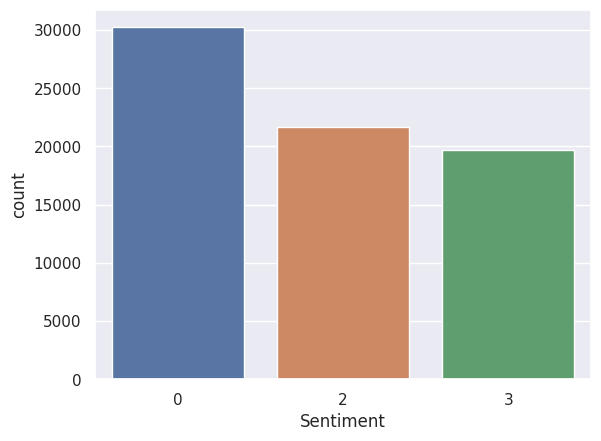

In [126]:
import seaborn as sns 

sns.set(style='darkgrid')
sns.countplot(data= train_df, x='Sentiment', order = train_df['Sentiment'].value_counts().index)

Positive-sentiment WordCloud

In [13]:
from wordcloud import WordCloud

def plot_wordcloud(number):

    word_cloud_df = test_df.loc[test_df['Sentiment'] == number,:]
    all_words = ' '.join([text for text in word_cloud_df['Tweet_Content_Split']])
 

    wordcloud = WordCloud(width = 500, height = 500, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

    #plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

Positive-sentiment WordCloud

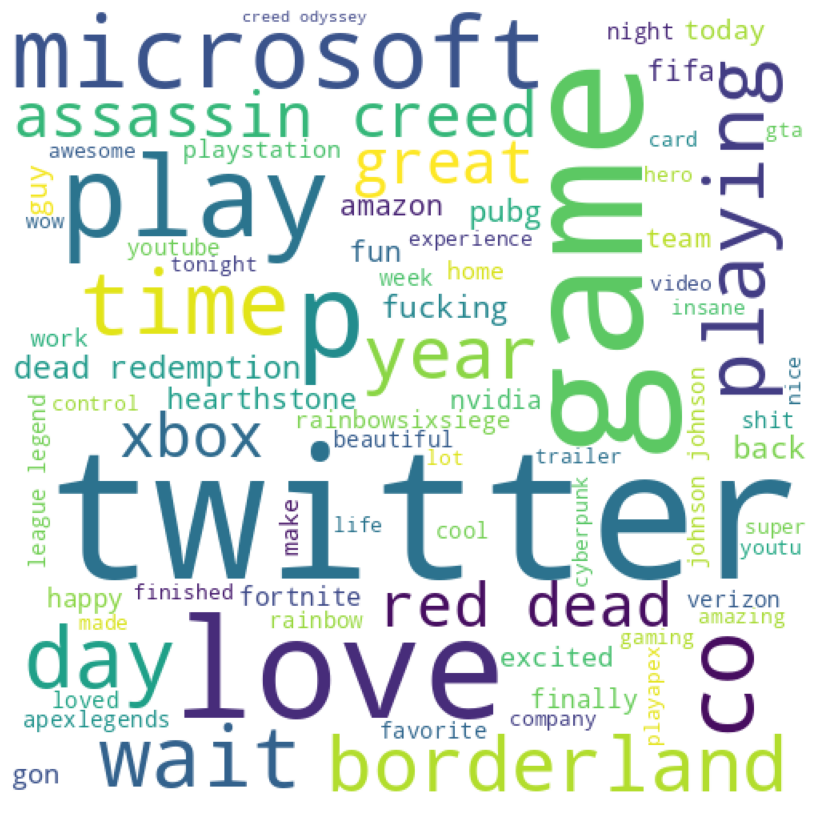

In [18]:
plot_wordcloud(3)

Negative-sentiment WordCloud

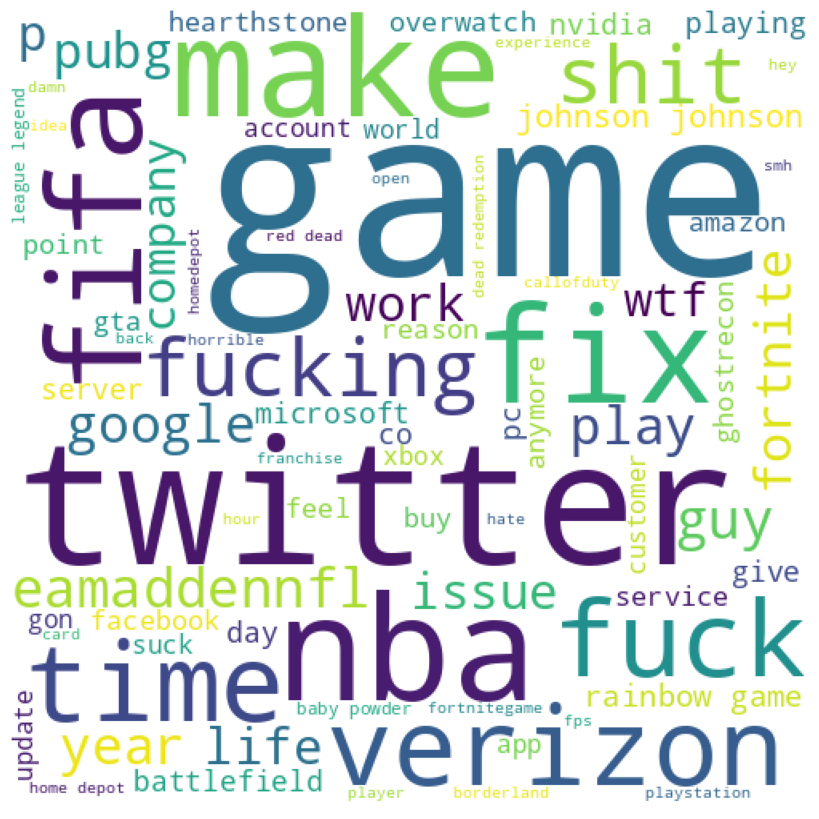

In [17]:
plot_wordcloud(2)

Neutral/Irrelevant-sentiment WorldCloud

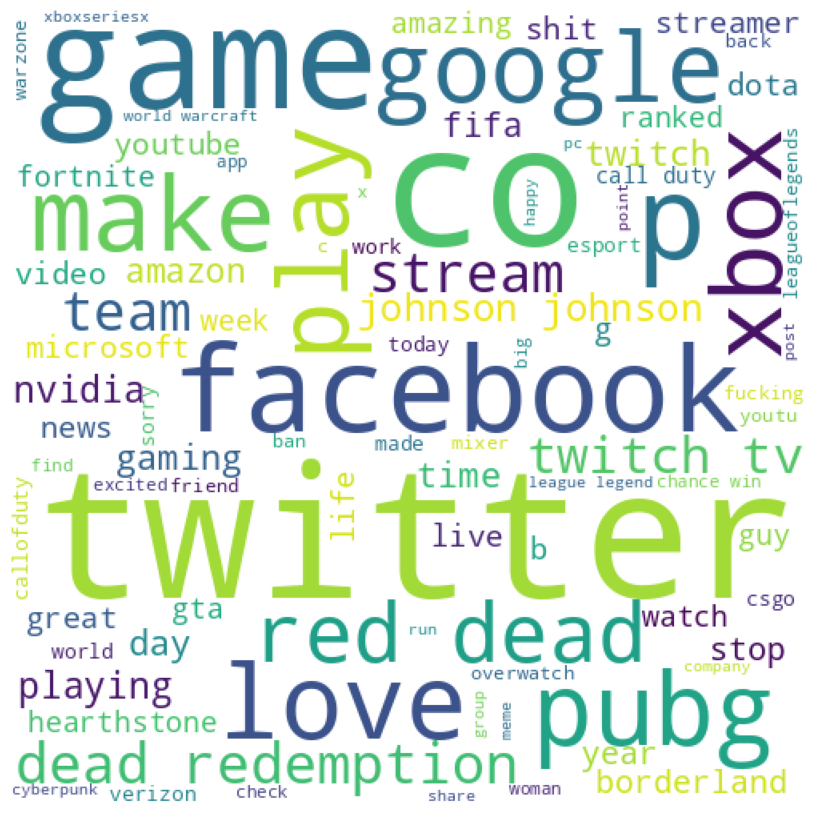

In [21]:
plot_wordcloud(0)

Tokenization: it is used to split paragraphs and sentences into smaller units that can be more easily assigned meaning.

In [138]:
tokenizer = Tokenizer(num_words= 2000, lower=True)

#Create the corpus by finding the most common 
tokenizer.fit_on_texts(train_df["Tweet_Content_Split"])

##Train
#Tokenise our column of edited Tweet content
tweet_tokens_train = tokenizer.texts_to_matrix(list(train_df["Tweet_Content_Split"]))

##Test
#Tokenise our column of edited Tweet content
tweet_tokens_test = tokenizer.texts_to_matrix(list(test_df["Tweet_Content_Split"]))

In [139]:
#Reset axes to avoid overlapping
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

##Train
train_full_df = pd.concat([train_df, pd.DataFrame(tweet_tokens_train)], sort=False, axis=1)

##Test
test_full_df = pd.concat([test_df, pd.DataFrame(tweet_tokens_test)], sort=False, axis=1)

In [142]:
# save dataframe to pickle file
train_full_df.to_pickle('train_full_df.pkl')
test_full_df.to_pickle('test_full_df.pkl')

In [1]:
import pandas as pd
train_full_df = pd.read_pickle('train_full_df.pkl')
test_full_df= pd.read_pickle('test_full_df.pkl')


In [2]:
#Removing columns that are not useful
##Train
ytrain= train_full_df['Sentiment']
train_full_df  = train_full_df .drop(["Sentiment", "Tweet_Content", "Tweet_Content_Split"], axis=1)


##Test
ytest=test_full_df['Sentiment']
test_full_df = test_full_df.drop(["Sentiment", "Tweet_Content", "Tweet_Content_Split"], axis=1)

In [3]:
print('Train size is: ', train_full_df.shape)
print('Test size is: ', train_full_df.shape)

Train size is:  (71656, 2032)
Test size is:  (71656, 2032)


In [4]:
#X_train, X_test, y_train, y_test = train_test_split(train_full_df, ytrain, test_size=0.2, random_state=1)

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(monitor= 'val_loss',mode='min',verbose=1, patience= 25)

2022-10-08 12:44:02.575291: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
model = Sequential()

model.add(Dense(12, input_dim=2032, activation='relu')),
model.add(Dense(8, activation='relu')),
model.add(Dense(50, activation='relu')),
model.add(Dropout(0.3))
model.add(Dense(12, activation='relu')),
model.add(Dense(50, activation='relu')),
model.add(Dropout(0.1))

#Multiclass Classification
model.add(Dense(4,activation='sigmoid'))
    
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [8]:
model.fit(train_full_df, ytrain, epochs= 30,callbacks=[early_stop])

Epoch 1/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.8084 - accuracy: 0.6353
Epoch 2/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.6188 - accuracy: 0.7447
Epoch 3/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.5230 - accuracy: 0.7909
Epoch 4/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.4594 - accuracy: 0.8204
Epoch 5/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.4180 - accuracy: 0.8365
Epoch 6/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.3870 - accuracy: 0.8480
Epoch 7/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.3627 - accuracy: 0.8591
Epoch 8/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.3447 - accuracy: 0.8665
Epoch 9/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.3279 - accuracy: 0.8722
Epoch 10/30
2240/2240 [==============================] - 5s 2ms/step - loss: 0.316

<AxesSubplot: >

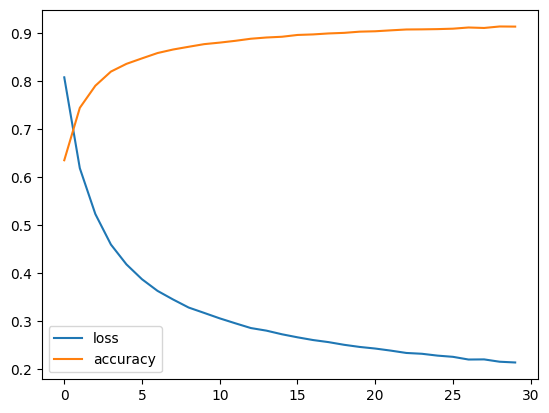

In [9]:
pd.DataFrame(model.history.history).plot()

In [12]:
import numpy as np
y_pred = np.argmax(model.predict(test_full_df), axis=1)

32/32 [==============================] - 0s 2ms/step


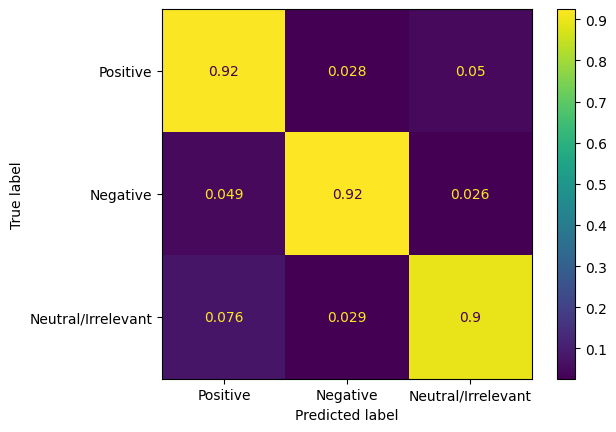

In [34]:

cm = confusion_matrix(ytest, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= y_unique)

disp.plot()

In [36]:
accuracy_score(ytest,y_pred)

0.915